In [1]:
import numpy as np
import pandas as pd
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from time import process_time

In [2]:
# _dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk'
_dir = '/Users/pmahableshwarkar/Documents/Depth_Project'

## Load Z-scored Data

In [3]:
final_discrim_path = _dir + '/depth_discrimination/data/finalDiscrimMatched/z_scored_RT/final_discrim.csv'


In [4]:
final_discrim = pd.read_csv(final_discrim_path)


In [5]:
final_discrim.columns

rmd = ['Unnamed: 0', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 
       'startTime', 'trial', 'log_fixation', 'log_sceneDuration1',
       'log_mask1', 'log_sceneDuration2', 'log_mask2', 'experimentTime',
       'totalTime', 'age', 'gender']

In [6]:
final_discrim.drop(columns=rmd, inplace=True)


In [7]:
# final_discrim

In [8]:
def add_accuracy_column(df):
    
    accuracy = []
    
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            accuracy.append('missed')
        else:    
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                accuracy.append(1)
            if type(correct_choice) == int:
                if choice != correct_choice:
                    accuracy.append(0)
                
    # Using DataFrame.insert() to add a column
    df.insert(7, "accuracy", accuracy, True)            
                
    return df

In [9]:
FINAL_discrim = add_accuracy_column(final_discrim)

In [10]:

FINAL_discrim.columns

Index(['subjID', 'z_scored_RT', 'cleaned_RT', 'stimulus_0', 'stimulus_1',
       'depth_difference', 'kinect_answer', 'accuracy', 'duration',
       'actual_depth_0', 'actual_depth_1', 'discrim_choice', 'trial_RT'],
      dtype='object')

In [11]:
final_discrim_125 = FINAL_discrim.loc[FINAL_discrim['duration'] == 125]
final_discrim_250 = FINAL_discrim.loc[FINAL_discrim['duration'] == 250]
final_discrim_1000 = FINAL_discrim.loc[FINAL_discrim['duration'] == 1000]

In [12]:
VE_data_125_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_125_data.csv'

VE_data_250_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_250_data.csv'

VE_data_1000_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_1000_data.csv'


In [13]:
VE_data_125 = pd.read_csv(VE_data_125_path)
VE_data_250 = pd.read_csv(VE_data_250_path)
VE_data_1000 = pd.read_csv(VE_data_1000_path)


In [14]:
rm = ['Unnamed: 0', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 'startTime', 'trial',
       'log_sceneDuration', 'unitSelection', 'seq_filepath', 'experimentTime',
       'totalTime', 'age', 'gender']


In [15]:
VE_data_125.drop(columns=rm, inplace=True)
VE_data_250.drop(columns=rm, inplace=True)
VE_data_1000.drop(columns=rm, inplace=True)


In [16]:
def get_stimuli(duration_df):
    """
    Args:
        duration df 
    Returns:
        all_stimuli
    """
    
    return list(duration_df.stimulus.unique())
#     stimuli = set()
#     for idx, row in duration_df.iterrows():
#         stimulus = row["stimulus"]
#         stimuli.add(stimulus)
        
#     return list(stimuli)

def rand_data(duration_df, proportion):
    """
    Args
        Data post outlier removal: i.e. cleaned_data 
        proportion - amount of data in each split (0.5 for 50/50 split)
    """
#     start_time = process_time()
    
    stimuli = get_stimuli(duration_df)
    
    rand0_y = []
    rand0_std = []
    rand0_ste = []
    rand0_stim = []
    
    rand0_all_ys = []
    
    rand0_subjIDs = []
    
    rand0_RTs = []
    
    rand1_y = []
    rand1_std = []
    rand1_ste = []
    rand1_stim = []
    
    rand1_all_ys = []
    
    rand1_subjIDs = []
    
    rand1_RTs = []
    
    rand0_stim_dfs = []
    rand1_stim_dfs = []

    grouped = duration_df.groupby(duration_df.stimulus) 
    for stim in stimuli:   
        stim_df = grouped.get_group(stim)
        stim_df_estimates = stim_df['depth_estimate'].tolist()
        stim_df_RTs = stim_df['trial_RT'].tolist()
        stim_df_subjIDs = stim_df['subjID'].tolist()
        
        # Shuffle two lists with same order
        # Using zip() + * operator + shuffle()
        temp = list(zip(stim_df_subjIDs, stim_df_estimates, stim_df_RTs))
        random.shuffle(temp)
        random.shuffle(temp)
        shuffled_subjIDs, shuffled_estimates, shuffled_RTs = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        shuffled_subjIDs, shuffled_estimates, shuffled_RTs = list(shuffled_subjIDs), list(shuffled_estimates), list(shuffled_RTs)
        
        rand0_all_ys.append(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        rand0_subjIDs.append(np.array(shuffled_subjIDs[0:int(len(shuffled_subjIDs)*proportion)]))
        rand0_RTs.append(np.array(shuffled_RTs[0:int(len(shuffled_RTs)*proportion)]))
        
        estim_avg_df0 = np.mean(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        estim_std0 = np.std(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        estim_ste0 = stats.sem(np.array(shuffled_estimates[0:int(len(shuffled_estimates)*proportion)]))
        
        rand0_y.append(estim_avg_df0) 
        rand0_std.append(estim_std0)
        rand0_ste.append(estim_ste0)
        rand0_stim.append(stim)
        
        # subjects included in split 0 for a particular stimulus
        stim_rand0_subjIDs = np.array(shuffled_subjIDs[0:int(len(shuffled_subjIDs)*proportion)])
        # keep data from subjects that are in the above list 
        stim_rand0_df = stim_df.loc[stim_df['subjID'].isin(stim_rand0_subjIDs)]
        rand0_stim_dfs.append(stim_rand0_df)
        
#         print(len(stim_df.subjID.unique()), len(stim_rand0_df.subjID.unique()))
        
        
        rand1_all_ys.append(np.array(shuffled_estimates[int(len(shuffled_estimates)*proportion):]))
        rand1_subjIDs.append(np.array(shuffled_subjIDs[int(len(shuffled_subjIDs)*proportion):]))
        rand1_RTs.append(np.array(shuffled_RTs[int(len(shuffled_RTs)*proportion):]))
        
        estim_avg_df1 = np.mean(np.array(shuffled_estimates[int(len(shuffled_estimates)*proportion):]))
        estim_std1 = np.std(np.array(shuffled_estimates[int(len(shuffled_estimates)*proportion):]))
        estim_ste1 = stats.sem(np.array(shuffled_estimates[int(len(shuffled_estimates)*proportion):]))
        
        rand1_y.append(estim_avg_df1) 
        rand1_std.append(estim_std1)
        rand1_ste.append(estim_ste1)
        rand1_stim.append(stim)
        
        # subjects included in split 1 for a particular stimulus
        stim_rand1_subjIDs = np.array(shuffled_subjIDs[int(len(shuffled_subjIDs)*proportion):])
        # keep data from subjects that are in the above list        
        stim_rand1_df = stim_df.loc[stim_df['subjID'].isin(stim_rand1_subjIDs)]
        rand1_stim_dfs.append(stim_rand1_df)

        
    # combine all stim dataframes for split 0
    rand0_df = pd.concat(rand0_stim_dfs)
    
    rand0_y = np.array(rand0_y).reshape(1,-1)[0]
    rand0_std = np.array(rand0_std).reshape(1,-1)[0]
    rand0_ste = np.array(rand0_ste).reshape(1,-1)[0]
    rand0_stim = np.array(rand0_stim).reshape(1,-1)[0]
    
    # combine all stim dataframes for split 1
    rand1_df = pd.concat(rand1_stim_dfs)

    rand1_y = np.array(rand1_y).reshape(1,-1)[0]
    rand1_std = np.array(rand1_std).reshape(1,-1)[0]
    rand1_ste = np.array(rand1_ste).reshape(1,-1)[0]
    rand1_stim = np.array(rand1_stim).reshape(1,-1)[0]
    
    
#     end_time = process_time()
#     print(f"rand_data: {(end_time - start_time)} seconds")
    return [rand0_y, rand0_std, rand0_ste, rand0_stim], rand0_df, [rand1_y, rand1_std, rand1_ste, rand1_stim], rand1_df



In [17]:
r0_125, r0_125_df, r1_125, r1_125_df = rand_data(VE_data_125, 0.5)
r0_250, r0_250_df, r1_250, r1_250_df = rand_data(VE_data_250, 0.5)
r0_1000, r0_1000_df, r1_1000, r1_1000_df = rand_data(VE_data_1000, 0.5)

In [17]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    acc = df['accuracy']
    

    missed = [a for a in list(df['accuracy']) if type(a) != int]
    accuracy = [a for a in list(df['accuracy']) if type(a) == int]
    
    
    # count correct/count total 
    prop_correct = sum(accuracy)/len(accuracy)
    
    # proportion of correct answers, count correct, count total, count missed 
    return prop_correct, sum(accuracy), len(accuracy), len(missed)

def get_RT(df):
    """    
    args:
        df  
    returns:
        array of RTs, avg RT, std, ste 
    """
    
    list_RTs = np.array(df['trial_RT'].tolist())
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)


def get_zscoredRT(df):
    """
    args:
        df  
    returns:
        array of zscored RTs, avg RT and std   
    """
    
    list_RTs = np.array(df['z_scored_RT'].tolist())
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [18]:
def individual_discrimination_stats(df, proportion):
    '''
    Individual discrimination performance and RT 
    '''
    
#     start_time = process_time()

    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str ]

    stimuli_stats_split0 = {}
    stimuli_stats_split1 = {}
    
    split0 = []
    split1 = []
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        #### SPLIT DATA INTO HALF AND CREATE STIMULI STATS PER HALF PER DURATION ####

        # Creating a dataframe with 50% values of original dataframe
        stim_125_df_split0 = stim_125_df.sample(frac = proportion, replace=False)
        split0.append(stim_125_df_split0)
        # Creating dataframe with rest of the 50% values
        stim_125_df_split1 = stim_125_df.drop(stim_125_df_split0.index)
        split1.append(stim_125_df_split1)
        
        # Creating a dataframe with 50% values of original dataframe
        stim_250_df_split0 = stim_250_df.sample(frac = proportion, replace=False)
        split0.append(stim_250_df_split0)
        # Creating dataframe with rest of the 50% values
        stim_250_df_split1 = stim_250_df.drop(stim_250_df_split0.index)
        split1.append(stim_250_df_split1)
        
        # Creating a dataframe with 50% values of original dataframe
        stim_1000_df_split0 = stim_1000_df.sample(frac = proportion, replace=False)
        split0.append(stim_1000_df_split0)
        # Creating dataframe with rest of the 50% values
        stim_1000_df_split1 = stim_1000_df.drop(stim_1000_df_split0.index)
        split1.append(stim_1000_df_split1)
        
        
        # SPLIT 0
        stim_acc_125_s0 = get_accuracy(stim_125_df_split0)
        stim_acc_250_s0 = get_accuracy(stim_250_df_split0)
        stim_acc_1000_s0 = get_accuracy(stim_1000_df_split0)

        stim_RT_125_s0 = get_RT(stim_125_df_split0)
        stim_RT_250_s0 = get_RT(stim_250_df_split0)
        stim_RT_1000_s0 = get_RT(stim_1000_df_split0)
        
        stim_zsRT_125_s0 = get_zscoredRT(stim_125_df_split0)
        stim_zsRT_250_s0 = get_zscoredRT(stim_250_df_split0)
        stim_zsRT_1000_s0 = get_zscoredRT(stim_1000_df_split0)
        
        stimuli_stats_split0[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125_s0,
                                    'accuracy_250': stim_acc_250_s0,
                                    'accuracy_1000': stim_acc_1000_s0,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'RT_125': stim_RT_125_s0,
                                    'RT_250': stim_RT_250_s0,
                                    'RT_1000': stim_RT_1000_s0,
                                    'zsRT_125': stim_zsRT_125_s0,
                                    'zsRT_250': stim_zsRT_250_s0,
                                    'zsRT_1000': stim_zsRT_1000_s0,
                                    'kinect_answer': kinect_answer}
        
        # SPLIT 1
        stim_acc_125_s1 = get_accuracy(stim_125_df_split1)
        stim_acc_250_s1 = get_accuracy(stim_250_df_split1)
        stim_acc_1000_s1 = get_accuracy(stim_1000_df_split1)

        stim_RT_125_s1 = get_RT(stim_125_df_split1)
        stim_RT_250_s1 = get_RT(stim_250_df_split1)
        stim_RT_1000_s1 = get_RT(stim_1000_df_split1)
        
        stim_zsRT_125_s1 = get_zscoredRT(stim_125_df_split0)
        stim_zsRT_250_s1 = get_zscoredRT(stim_250_df_split0)
        stim_zsRT_1000_s1 = get_zscoredRT(stim_1000_df_split0)

        stimuli_stats_split1[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125_s1,
                                    'accuracy_250': stim_acc_250_s1,
                                    'accuracy_1000': stim_acc_1000_s1,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'RT_125': stim_RT_125_s1,
                                    'RT_250': stim_RT_250_s1,
                                    'RT_1000': stim_RT_1000_s1,
                                    'zsRT_125': stim_zsRT_125_s1,
                                    'zsRT_250': stim_zsRT_250_s1,
                                    'zsRT_1000': stim_zsRT_1000_s1,
                                    'kinect_answer': kinect_answer}
        
    end_time = process_time()
#     print(f"rand_data: {(end_time - start_time)} seconds")
    
    return stimuli_stats_split0, pd.concat(split0), stimuli_stats_split1, pd.concat(split1)


In [20]:
all_discrim_performance_s0, final_discrim_s0, all_discrim_performance_s1, final_discrim_s1 = individual_discrimination_stats(FINAL_discrim, 0.5)

In [19]:
def get_answerkey(discrim_performance, VE_data):
    '''
    Generates discrimination trial answer key based off of verbal judgement data
    '''
    answerkey = {}
    
    final_y = VE_data[0]
    final_std = VE_data[1]
    final_ste = VE_data[2]
    final_stim = VE_data[3]

    for key in discrim_performance.keys():
        targetimg0 = key.split('/')[-1]
        folder0 = targetimg0[:-11]
        depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
        idx0 = np.where(final_stim == depth_dur_path0)[0][0]
        avg_estim_stim0 = final_y[idx0]
        std0 = final_std[idx0]
        ste0 = final_ste[idx0]
    
        targetimg1 = discrim_performance[key]['stimulus_1'].split('/')[-1]
        folder1 = targetimg1[:-11]
        depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
        idx1= np.where(final_stim == depth_dur_path1)[0][0]
        avg_estim_stim1 = final_y[idx1]
        std1 = final_std[idx1]
        ste1 = final_ste[idx1]
    
        kinect_answer = discrim_performance[key]['kinect_answer'].split('/')[-1]

        if avg_estim_stim0 < avg_estim_stim1:
            # Which target is CLOSER to you?
            answer = targetimg0
        if avg_estim_stim0 == avg_estim_stim1:
            print(targetimg0, targetimg1)
        if avg_estim_stim0 > avg_estim_stim1:
            answer = targetimg1

        answerkey[key] = {'stimulus_1': targetimg1,
                                   'stimulus_0_avg_estim': avg_estim_stim0,
                                   'stimulus_1_avg_estim': avg_estim_stim1,
                                   'answer': answer,
                                   'std0': std0,
                                   'std1': std1,
                                   'kinect_answer': kinect_answer}
        
    return answerkey
    

In [22]:
ak0_125 = get_answerkey(all_discrim_performance_s0, r0_125)
ak0_250 = get_answerkey(all_discrim_performance_s0, r0_250)
ak0_1000 = get_answerkey(all_discrim_performance_s0, r0_1000)

ak1_125 = get_answerkey(all_discrim_performance_s1, r1_125)
ak1_250 = get_answerkey(all_discrim_performance_s1, r1_250)
ak1_1000 = get_answerkey(all_discrim_performance_s1, r1_1000)

### VE Coded Accuracy

In [20]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0: image_choice = row["stimulus_0"]
                
        if choice == 1.0: image_choice = row["stimulus_1"]
                
        if choice == 2.0: count_missed += 1
            
        if choice == 3.0: count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer: count_correct += 1
        except: pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_coded_discrim_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    '''
    Args:
        df: final discrimination dataframe
        answerkey_250 & answerkey_1000: VE coded answer key
    '''
#     start_time = process_time()
    
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]

        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

        stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

        stim_RT_125 = get_RT(stim_125_df)
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)

        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            
        std0_125 = answerkey_125[stim0]['std0']
        std1_125 = answerkey_125[stim0]['std1']
        joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
        JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

        std0_250 = answerkey_250[stim0]['std0']
        std1_250 = answerkey_250[stim0]['std1']
        joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
        JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

        std0_1000 = answerkey_1000[stim0]['std0']
        std1_1000 = answerkey_1000[stim0]['std1']
        joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
        JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
        if stim_acc_125[-1] == 'pos':
            VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
        if stim_acc_250[-1] == 'pos':
            VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
        if stim_acc_1000[-1] == 'pos':
            VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
        else:
            VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_125': VE_depthdifference_125,
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': stim_RT_125,
                                    'RT_250': stim_RT_250,
                                    'RT_1000': stim_RT_1000,
                                    'zsRT_125': get_zscoredRT(stim_125_df),
                                    'zsRT_250': get_zscoredRT(stim_250_df),
                                    'zsRT_1000': get_zscoredRT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000}


#     end_time = process_time()
#     print(f"main_VE_coded_discrim_accuracy: {(end_time - start_time)} seconds")
    
    return stimuli_stats
    

In [24]:
VE_coded_discrim_performance0 = main_VE_coded_discrim_accuracy(final_discrim_s0, ak0_125, ak0_250, ak0_1000)
VE_coded_discrim_performance1 = main_VE_coded_discrim_accuracy(final_discrim_s1, ak1_125, ak1_250, ak1_1000)

In [21]:
def get_discrimination_results(discrim_performance, duration):
    '''
    Returns lists of discrimination data results
    '''
    if duration == 125:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_125'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_125'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_125'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_125'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_125'][-1] for elem in discrim_performance]
        n_avg_zsRT = [discrim_performance[elem]['zsRT_125'][1] for elem in discrim_performance]
        n_avg_zsRT_ste = [discrim_performance[elem]['zsRT_125'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_125'] for elem in discrim_performance]
        
    if duration == 250:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_250'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_250'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_250'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_250'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_250'][-1] for elem in discrim_performance]
        n_avg_zsRT = [discrim_performance[elem]['zsRT_250'][1] for elem in discrim_performance]
        n_avg_zsRT_ste = [discrim_performance[elem]['zsRT_250'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_250'] for elem in discrim_performance]
        
    if duration == 1000:
        n_VE_estim_diff = [discrim_performance[elem]['VE_depthdifference_1000'] for elem in discrim_performance]
        n_VE_accuracy = [discrim_performance[elem]['accuracy_1000'][0] for elem in discrim_performance]
        n_VE_ste = [discrim_performance[elem]['accuracy_1000'][-2] for elem in discrim_performance]
        n_avg_RT = [discrim_performance[elem]['RT_1000'][1] for elem in discrim_performance]
        n_avg_RT_ste = [discrim_performance[elem]['RT_1000'][-1] for elem in discrim_performance]
        n_avg_zsRT = [discrim_performance[elem]['zsRT_1000'][1] for elem in discrim_performance]
        n_avg_zsRT_ste = [discrim_performance[elem]['zsRT_1000'][-1] for elem in discrim_performance]
        n_JV = [discrim_performance[elem]['JV_regressor_1000'] for elem in discrim_performance]

    n_stim = [elem for elem in discrim_performance]      
    
    return n_VE_estim_diff, n_VE_accuracy, n_VE_ste, n_avg_RT, n_avg_RT_ste, n_JV, n_stim

In [26]:
discrimination_results0_125 = get_discrimination_results(VE_coded_discrim_performance0, 125)
discrimination_results0_250 = get_discrimination_results(VE_coded_discrim_performance0, 250)
discrimination_results0_1000 = get_discrimination_results(VE_coded_discrim_performance0, 1000)

discrimination_results1_125 = get_discrimination_results(VE_coded_discrim_performance1, 125)
discrimination_results1_250 = get_discrimination_results(VE_coded_discrim_performance1, 250)
discrimination_results1_1000 = get_discrimination_results(VE_coded_discrim_performance1, 1000)

https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d



### Derive Performance for VE 

In [22]:
def VE_performance(stimuli, duration_df, discrimination_performance, duration_answerkey):
    '''
    Args:
        stimuli:  depth discrimination stimuli list 
        duration_df: filtered VE duration dataframe 
        discrimination performance: dictionary of discrim performance 
    '''
#     start_time = process_time()

    VE_Performance = {}
            
    for im0 in stimuli:
        performance = []
        # loop through all participants
        for subjID in duration_df.subjID.unique():
            # filter to just the subjects data df
            subjdf = duration_df.loc[duration_df['subjID'] == subjID]
            
            try:
                im0_VE = 'depth_duration_stimuli/' + im0.split('/')[1] + '/' + im0.split('/')[2]
                im0_row = subjdf.loc[subjdf['stimulus'] == im0_VE]
                im0_estimate = im0_row['depth_estimate'].tolist()[0]

                im1 = discrimination_performance[im0]['stimulus_1'][29:]
                im1_VE = 'depth_duration_stimuli/' + im1
                im1_row = subjdf.loc[subjdf['stimulus'] == im1_VE]
                im1_estimate = im1_row['depth_estimate'].tolist()[0]
                

                if im0_estimate < im1_estimate:
                    p_ans = im0.split('/')[-1]
                else:
                    p_ans = im1.split('/')[-1]
                try:
                    answerkey_answer = duration_answerkey[im0]['answer']
                except:
                    answerkey_answer = duration_answerkey['depth_discrimination_stimuli/' + im1]['answer']
                if p_ans == answerkey_answer:
                    trial_acc = 0 # CORRECT
                    performance.append(trial_acc)
                else:
                    trial_acc = 1 # INCORRECT
                    performance.append(trial_acc)
            
            except:
                pass
        VE_Performance[im0] = performance
        
#     print(f"main_VE_coded_discrim_accuracy: {(process_time() - start_time)} seconds")


    VE_PC = {}

    for key in VE_Performance:
        performance = VE_Performance[key]
        correct_count = performance.count(0)
        incorrect_count = performance.count(1)
        total = len(performance)
        pc = correct_count/total
        VE_PC[key] = pc
        
    
    
    return VE_PC
    

In [28]:
VE_performance0_125 = VE_performance(discrimination_results0_125[-1], r0_125_df, VE_coded_discrim_performance0, ak0_125)
VE_performance0_250 = VE_performance(discrimination_results0_250[-1], r0_250_df, VE_coded_discrim_performance0, ak0_250)
VE_performance0_1000 = VE_performance(discrimination_results0_1000[-1], r0_1000_df, VE_coded_discrim_performance0, ak0_1000)

VE_performance1_125 = VE_performance(discrimination_results1_125[-1], r1_125_df, VE_coded_discrim_performance1, ak1_125)
VE_performance1_250 = VE_performance(discrimination_results1_250[-1], r1_250_df, VE_coded_discrim_performance1, ak1_250)
VE_performance1_1000 = VE_performance(discrimination_results1_1000[-1], r1_1000_df, VE_coded_discrim_performance1, ak1_1000)

### Matched Discrimination Performance (Accuracy and RT)

In [23]:
def matched_performance(VE_Performance, discrimination_performance, duration):
    '''
    Args:
        VE_performance: dict of VE performance for a specific duration
        discrimination_performance: complete discrim performance
        duration: int, duration value
    Returns:
        Trial matched VE and Discrimination performance
        List of stimuli 
        
    '''
    Discrim_VEmatched_PC = {}
    all_stim = []
    all_VE_PC = []
    all_Discrim_VEmatched_PC = []

    for key in VE_Performance:
        
        im_VE_PC = VE_Performance[key]
        if duration == 125:
            im_Discrim_PC = discrimination_performance[key]['accuracy_125'][0]
        if duration == 250:
            im_Discrim_PC = discrimination_performance[key]['accuracy_250'][0]
        if duration == 1000:
            im_Discrim_PC = discrimination_performance[key]['accuracy_1000'][0]
        Discrim_VEmatched_PC[key] = [im_VE_PC, im_Discrim_PC]

        all_stim.append(key)
        all_VE_PC.append(im_VE_PC)
        all_Discrim_VEmatched_PC.append(im_Discrim_PC)
        
    return all_Discrim_VEmatched_PC, all_VE_PC, all_stim

In [30]:
m_discrim_performance0_125, m_VE_performance0_125, m_stim0_125 = matched_performance(VE_performance0_125, VE_coded_discrim_performance0, 125)
m_discrim_performance0_250, m_VE_performance0_250, m_stim0_250 = matched_performance(VE_performance0_250, VE_coded_discrim_performance0, 250)
m_discrim_performance0_1000, m_VE_performance0_1000, m_stim0_1000 = matched_performance(VE_performance0_1000, VE_coded_discrim_performance0, 1000)

m_discrim_performance1_125, m_VE_performance1_125, m_stim1_125 = matched_performance(VE_performance1_125, VE_coded_discrim_performance1, 125)
m_discrim_performance1_250, m_VE_performance1_250, m_stim1_250 = matched_performance(VE_performance1_250, VE_coded_discrim_performance1, 250)
m_discrim_performance1_1000, m_VE_performance1_1000, m_stim1_1000 = matched_performance(VE_performance1_1000, VE_coded_discrim_performance1, 1000)

In [24]:
def get_RT_performance(duration_df, discrimination_performance, duration, zscoredRT = True):
    '''
    Args:
        duration_df: filtered VE duration dataframe
        discrimination_performance: dict of discrimination performance
        duration: int value for duration 
    ReturnsL
    arr_discrim_RT: array of RTs for discrimination trials
    arr_discrim_RT_ste: array of ste of RT for each discrimination trial
    arr_VE_RT: array of RTs for VE trials
    stim_RT: list of stimuli that is matched with arr_discrim_RT and arr_VE_RT 
    '''
    
    
    arr_discrim_RT = []
    arr_discrim_RT_ste = []
    arr_VE_RT = []
    stim_RT = []

#     start_time = process_time()
    for key in discrimination_performance:
        stim_RT.append(key)
        im0 = key.split('/')[1]
        im1 = discrimination_performance[key]['stimulus_1'].split('/')[1]
        
        if zscoredRT == True:
            dur_key = 'zsRT_' + str(duration)
        else:
            dur_key = 'RT_' + str(duration)
        dtrial_RT = discrimination_performance[key][dur_key][1]
        dtrial_RT_ste = discrimination_performance[key][dur_key][-1]

            
        arr_discrim_RT.append(dtrial_RT)
        arr_discrim_RT_ste.append(dtrial_RT_ste)
        
        
        RTs = []
        # loop through all participants
        for subjID in duration_df.subjID.unique():
            # filter to just the subjects data df
            subjdf = duration_df.loc[duration_df['subjID'] == subjID]
            
            im0_VE = 'depth_duration_stimuli/' + key.split('/')[1] + '/' + key.split('/')[2]
            im0_row = subjdf.loc[subjdf['stimulus'] == im0_VE]
            if len(im0_row) > 0:
                im0_RT = im0_row['trial_RT'].tolist()[0]

                im1 = discrimination_performance[key]['stimulus_1'][29:]
                im1_VE = 'depth_duration_stimuli/' + im1

                im1_row = subjdf.loc[subjdf['stimulus'] == im1_VE]
                if len(im1_row) > 0:
                    im1_RT = im1_row['trial_RT'].tolist()[0]

                    RTs.append(im0_RT + im1_RT)
            

        arr_VE_RT.append(np.mean(np.array(RTs)))
        
#     print(f"end: {(process_time() - start_time)} seconds")

        
    return arr_discrim_RT, arr_discrim_RT_ste, arr_VE_RT, stim_RT


In [32]:
m_discrim_RT0_125, m_discrim_RT0_ste_125, m_VE_RT0_125, m_RT0_stim_125 = get_RT_performance(r0_125_df, VE_coded_discrim_performance0, 125) 
m_discrim_RT0_250, m_discrim_RT0_ste_250, m_VE_RT0_250, m_RT0_stim_250 = get_RT_performance(r0_250_df, VE_coded_discrim_performance0, 250) 
m_discrim_RT0_1000, m_discrim_RT0_ste_1000, m_VE_RT0_1000, m_RT0_stim_1000 = get_RT_performance(r0_1000_df, VE_coded_discrim_performance0, 1000)

m_discrim_RT1_125, m_discrim_RT1_ste_125, m_VE_RT1_125, m_RT1_stim_125 = get_RT_performance(r1_125_df, VE_coded_discrim_performance1, 125) 
m_discrim_RT1_250, m_discrim_RT1_ste_250, m_VE_RT1_250, m_RT1_stim_250 = get_RT_performance(r1_250_df, VE_coded_discrim_performance1, 250) 
m_discrim_RT1_1000, m_discrim_RT1_ste_1000, m_VE_RT1_1000, m_RT1_stim_1000 = get_RT_performance(r1_1000_df, VE_coded_discrim_performance1, 1000)

In [33]:
# STATS FOR DISCRIMINATION MATRIX FIGURE
# accuracy between duration correlations (between splits)
print(stats.pearsonr(m_discrim_performance0_125, m_discrim_performance1_250))
print(stats.pearsonr(m_discrim_performance0_125, m_discrim_performance1_1000))
print(stats.pearsonr(m_discrim_performance0_1000, m_discrim_performance1_250))

print()

# RT between duration correlations (between splits)
print(stats.pearsonr(m_discrim_RT0_125, m_discrim_RT1_250))
print(stats.pearsonr(m_discrim_RT0_125, m_discrim_RT1_1000))
print(stats.pearsonr(m_discrim_RT0_1000, m_discrim_RT1_250))

(0.7838732765646907, 1.0941556847731746e-33)
(0.6675379786343704, 1.7929547540700528e-21)
(0.7627045703294926, 5.973713859690226e-31)

(0.7471227764624888, 4.1196268806872784e-29)
(0.6391139778125785, 2.7564655660626374e-19)
(0.5735976507344882, 5.015163879670961e-15)


In [34]:
# STATS FOR JOINT VARIANCE MATRIX FIGURE
print(stats.pearsonr(m_discrim_performance0_125, m_VE_performance1_125))
print(stats.pearsonr(m_discrim_RT0_125, m_VE_RT1_250))
print(stats.pearsonr(m_discrim_RT0_125, m_VE_performance1_1000))


(0.5832391525251505, 1.3575584653966462e-15)
(0.27899027898450784, 0.0004205258728385779)
(-0.487530007504757, 1.084648076898825e-10)


In [35]:
# fig, ax = plt.subplots(figsize=[9,9])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)

# #run regression
# X = np.array(m_VE_performance0_1000).reshape(-1,1)
# Y = m_discrim_performance0_1000
# reg = LinearRegression().fit(X, Y)

# #Generated Predictions
# predicted_Y = reg.predict(X)
# #Plot Our Actual and Predicted Values

# plt.errorbar(X, Y, elinewidth=1, ecolor='gray', fmt='or', mfc='darkviolet', mec='darkviolet', capsize=3, alpha = 1);
# plt.plot(X, Y, 'o', color='darkviolet', alpha = 1);
# plt.plot(X, predicted_Y,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
#          + '     r-squared = ' + str(round(float(reg.score(X, Y)**2), 3)))

# plt.ylabel("Discrimination Percent Correct", fontsize = 18)
# plt.xlabel("Metric Estimate Percent Correct", fontsize = 18)

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.margins(x=0.02)

# #get coefficients and y intercept
# print("m: {0}".format(reg.coef_))
# print("b: {0}".format(reg.intercept_))
# #Returns the coefficient of determination R^2 of the prediction.
# print("R-squared: ", reg.score(X, Y))

# legend = plt.legend(loc = 2, fontsize=15, labelspacing=1, frameon=False)
# plt.show();


## Main: Split and run analyses X num of times

In [41]:
# list(m_discrim_performance0_125 - np.mean(np.array(m_discrim_performance0_125)))

In [40]:
%%time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, as_completed


dfs = [] 
    
def run_analysis():
    
    r0_125, r0_125_df, r1_125, r1_125_df = rand_data(VE_data_125, 0.5)
    r0_250, r0_250_df, r1_250, r1_250_df = rand_data(VE_data_250, 0.5)
    r0_1000, r0_1000_df, r1_1000, r1_1000_df = rand_data(VE_data_1000, 0.5)
    
    all_discrim_performance_s0, final_discrim_s0, all_discrim_performance_s1, final_discrim_s1 = individual_discrimination_stats(FINAL_discrim, 0.5)
    
    ak0_125 = get_answerkey(all_discrim_performance_s0, r0_125)
    ak0_250 = get_answerkey(all_discrim_performance_s0, r0_250)
    ak0_1000 = get_answerkey(all_discrim_performance_s0, r0_1000)

    ak1_125 = get_answerkey(all_discrim_performance_s1, r1_125)
    ak1_250 = get_answerkey(all_discrim_performance_s1, r1_250)
    ak1_1000 = get_answerkey(all_discrim_performance_s1, r1_1000)

    VE_coded_discrim_performance0 = main_VE_coded_discrim_accuracy(final_discrim_s0, ak0_125, ak0_250, ak0_1000)
    VE_coded_discrim_performance1 = main_VE_coded_discrim_accuracy(final_discrim_s1, ak1_125, ak1_250, ak1_1000)

    discrimination_results0_125 = get_discrimination_results(VE_coded_discrim_performance0, 125)
    discrimination_results0_250 = get_discrimination_results(VE_coded_discrim_performance0, 250)
    discrimination_results0_1000 = get_discrimination_results(VE_coded_discrim_performance0, 1000)

    discrimination_results1_125 = get_discrimination_results(VE_coded_discrim_performance1, 125)
    discrimination_results1_250 = get_discrimination_results(VE_coded_discrim_performance1, 250)
    discrimination_results1_1000 = get_discrimination_results(VE_coded_discrim_performance1, 1000)

    VE_performance0_125 = VE_performance(discrimination_results0_125[-1], r0_125_df, VE_coded_discrim_performance0, ak0_125)
    VE_performance0_250 = VE_performance(discrimination_results0_250[-1], r0_250_df, VE_coded_discrim_performance0, ak0_250)
    VE_performance0_1000 = VE_performance(discrimination_results0_1000[-1], r0_1000_df, VE_coded_discrim_performance0, ak0_1000)

    VE_performance1_125 = VE_performance(discrimination_results1_125[-1], r1_125_df, VE_coded_discrim_performance1, ak1_125)
    VE_performance1_250 = VE_performance(discrimination_results1_250[-1], r1_250_df, VE_coded_discrim_performance1, ak1_250)
    VE_performance1_1000 = VE_performance(discrimination_results1_1000[-1], r1_1000_df, VE_coded_discrim_performance1, ak1_1000)

    m_discrim_performance0_125, m_VE_performance0_125, m_stim0_125 = matched_performance(VE_performance0_125, VE_coded_discrim_performance0, 125)
    m_discrim_performance0_250, m_VE_performance0_250, m_stim0_250 = matched_performance(VE_performance0_250, VE_coded_discrim_performance0, 250)
    m_discrim_performance0_1000, m_VE_performance0_1000, m_stim0_1000 = matched_performance(VE_performance0_1000, VE_coded_discrim_performance0, 1000)

    m_discrim_performance1_125, m_VE_performance1_125, m_stim1_125 = matched_performance(VE_performance1_125, VE_coded_discrim_performance1, 125)
    m_discrim_performance1_250, m_VE_performance1_250, m_stim1_250 = matched_performance(VE_performance1_250, VE_coded_discrim_performance1, 250)
    m_discrim_performance1_1000, m_VE_performance1_1000, m_stim1_1000 = matched_performance(VE_performance1_1000, VE_coded_discrim_performance1, 1000)

    m_discrim_RT0_125, m_discrim_RT0_ste_125, m_VE_RT0_125, m_RT0_stim_125 = get_RT_performance(r0_125_df, VE_coded_discrim_performance0, 125) 
    m_discrim_RT0_250, m_discrim_RT0_ste_250, m_VE_RT0_250, m_RT0_stim_250 = get_RT_performance(r0_250_df, VE_coded_discrim_performance0, 250) 
    m_discrim_RT0_1000, m_discrim_RT0_ste_1000, m_VE_RT0_1000, m_RT0_stim_1000 = get_RT_performance(r0_1000_df, VE_coded_discrim_performance0, 1000)

    m_discrim_RT1_125, m_discrim_RT1_ste_125, m_VE_RT1_125, m_RT1_stim_125 = get_RT_performance(r1_125_df, VE_coded_discrim_performance1, 125) 
    m_discrim_RT1_250, m_discrim_RT1_ste_250, m_VE_RT1_250, m_RT1_stim_250 = get_RT_performance(r1_250_df, VE_coded_discrim_performance1, 250) 
    m_discrim_RT1_1000, m_discrim_RT1_ste_1000, m_VE_RT1_1000, m_RT1_stim_1000 = get_RT_performance(r1_1000_df, VE_coded_discrim_performance1, 1000)

    
    data = {'r0_Discrim_PC_125': m_discrim_performance0_125,
        'r0_Discrim_PC_250': m_discrim_performance0_250,
        'r0_Discrim_PC_1000': m_discrim_performance0_1000,
        'r0_VE_PC_125': m_VE_performance0_125,
        'r0_VE_PC_250': m_VE_performance0_250,
        'r0_VE_PC_1000': m_VE_performance0_1000,
        'r0_Discrim 125 RT': m_discrim_RT0_125,
        'r0_Discrim 250 RT': m_discrim_RT0_250,
        'r0_Discrim 1000 RT': m_discrim_RT0_1000,
        'r0_VE 125 RT': m_VE_RT0_125,
        'r0_VE 250 RT': m_VE_RT0_250,
        'r0_VE 1000 RT': m_VE_RT0_1000,  
        'r1_Discrim_PC_125': m_discrim_performance1_125,
        'r1_Discrim_PC_250': m_discrim_performance1_250,
        'r1_Discrim_PC_1000': m_discrim_performance1_1000,
        'r1_VE_PC_125': m_VE_performance1_125,
        'r1_VE_PC_250': m_VE_performance1_250,
        'r1_VE_PC_1000': m_VE_performance1_1000,
        'r1_Discrim 125 RT': m_discrim_RT1_125,
        'r1_Discrim 250 RT': m_discrim_RT1_250,
        'r1_Discrim 1000 RT': m_discrim_RT1_1000,
        'r1_VE 125 RT': m_VE_RT1_125,
        'r1_VE 250 RT': m_VE_RT1_250,
        'r1_VE 1000 RT': m_VE_RT1_1000
        }
    
    
    data_IES = {'r0_discrim_IES_125': np.array(m_discrim_RT0_125)/np.array(m_discrim_performance0_125),
                'r0_discrim_IES_250': np.array(m_discrim_RT0_250)/np.array(m_discrim_performance0_250),
                'r0_discrim_IES_1000': np.array(m_discrim_RT0_1000)/np.array(m_discrim_performance0_1000),
                'r1_discrim_IES_125': np.array(m_discrim_RT1_125)/np.array(m_discrim_performance1_125),
                'r1_discrim_IES_250': np.array(m_discrim_RT1_250)/m_discrim_performance1_250,
                'r1_discrim_IES_1000': np.array(m_discrim_RT1_1000)/np.array(m_discrim_performance1_1000),
                'r0_VE_IES_125': np.array(m_VE_RT0_125)/np.array(m_VE_performance0_125),
                'r0_VE_IES_250': np.array(m_VE_RT0_250)/np.array(m_VE_performance0_250),
                'r0_VE_IES_1000': np.array(m_VE_RT0_1000)/np.array(m_VE_performance0_1000),
                'r1_VE_IES_125': np.array(m_VE_RT1_125)/np.array(m_VE_performance1_125),
                'r1_VE_IES_250': np.array(m_VE_RT1_250)/np.array(m_VE_performance1_250),
                'r1_VE_IES_1000': np.array(m_VE_RT1_1000)/np.array(m_VE_performance1_1000)}
    

    df = pd.DataFrame(data_IES,columns=['r0_discrim_IES_125', 'r0_discrim_IES_250', 'r0_discrim_IES_1000', 
                                        'r1_discrim_IES_125', 'r1_discrim_IES_250', 'r1_discrim_IES_1000',
                                        'r0_VE_IES_125', 'r0_VE_IES_250', 'r0_VE_IES_1000', 
                                        'r1_VE_IES_125', 'r1_VE_IES_250', 'r1_VE_IES_1000'])

    df_corr = df.corr()
    
    return df_corr    

# save each correlation matrix
p = '/Users/pmahableshwarkar/Documents/Depth_Project/matrices/ies/'


reps = 2
dfs = []
import multiprocessing as mp

executor = ProcessPoolExecutor(max_workers=mp.cpu_count()//4)
for i in range(reps):
    print("Enqueuing run_analysis rep: ", i)
    dfs.append(executor.submit(run_analysis))

for count, future in enumerate(as_completed(dfs)):
    print("Rep completed :", count)
    dest = p + 'ies-' + str(count) + '.pkl'
    dfs[count].result().to_pickle(dest)
    
df_sum = 0
for i, df in enumerate(dfs):
    df_sum += df.result()
#     dest = p + 'ies-' + str(i) + '.pkl'
#     df.result().to_pickle(dest)

mean_df_corr = df_sum / len(dfs)
executor.shutdown(wait=True)

mean_df_corr.to_csv('avg_IES_randSplitMatrix_n' + str(reps) + '.csv')

Enqueuing run_analysis rep:  0
Enqueuing run_analysis rep:  1
Enqueuing run_analysis rep:  2
Enqueuing run_analysis rep:  3
Enqueuing run_analysis rep:  4
Enqueuing run_analysis rep:  5
Enqueuing run_analysis rep:  6
Enqueuing run_analysis rep:  7
Enqueuing run_analysis rep:  8
Enqueuing run_analysis rep:  9
Enqueuing run_analysis rep:  10
Enqueuing run_analysis rep:  11
Enqueuing run_analysis rep:  12
Enqueuing run_analysis rep:  13
Enqueuing run_analysis rep:  14
Enqueuing run_analysis rep:  15
Enqueuing run_analysis rep:  16
Enqueuing run_analysis rep:  17
Enqueuing run_analysis rep:  18
Enqueuing run_analysis rep:  19
Enqueuing run_analysis rep:  20
Enqueuing run_analysis rep:  21
Enqueuing run_analysis rep:  22
Enqueuing run_analysis rep:  23
Enqueuing run_analysis rep:  24
Enqueuing run_analysis rep:  25
Enqueuing run_analysis rep:  26
Enqueuing run_analysis rep:  27
Enqueuing run_analysis rep:  28
Enqueuing run_analysis rep:  29
Enqueuing run_analysis rep:  30
Enqueuing run_anal

/Users/pmahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide


Rep completed : 2314
Rep completed : 2315
Rep completed : 2316
Rep completed : 2317
Rep completed : 2318
Rep completed : 2319
Rep completed : 2320
Rep completed : 2321
Rep completed : 2322
Rep completed : 2323
Rep completed : 2324
Rep completed : 2325
Rep completed : 2326
Rep completed : 2327
Rep completed : 2328
Rep completed : 2329
Rep completed : 2330
Rep completed : 2331
Rep completed : 2332
Rep completed : 2333
Rep completed : 2334
Rep completed : 2335
Rep completed : 2336
Rep completed : 2337
Rep completed : 2338
Rep completed : 2339
Rep completed : 2340
Rep completed : 2341
Rep completed : 2342
Rep completed : 2343
Rep completed : 2344
Rep completed : 2345
Rep completed : 2346
Rep completed : 2347
Rep completed : 2348
Rep completed : 2349
Rep completed : 2350
Rep completed : 2351
Rep completed : 2352
Rep completed : 2353
Rep completed : 2354
Rep completed : 2355
Rep completed : 2356
Rep completed : 2357
Rep completed : 2358
Rep completed : 2359
Rep completed : 2360
Rep completed

In [41]:
len(dfs)
# dfs[0].result()

5000

In [42]:
mean_df_corr.to_csv('/Users/pmahableshwarkar/Documents/Depth_Project/spatial_perception_SUNRGBD/joint_analyses/IES_rand_splitMatrix_' + str(reps) + '.csv')

In [43]:
mean_df_corr

,r0_discrim_IES_125,r0_discrim_IES_250,r0_discrim_IES_1000,r1_discrim_IES_125,r1_discrim_IES_250,r1_discrim_IES_1000,r0_VE_IES_125,r0_VE_IES_250,r0_VE_IES_1000,r1_VE_IES_125,r1_VE_IES_250,r1_VE_IES_1000
r0_discrim_IES_125,1.000000,0.713201,0.621346,0.796104,0.710380,0.623895,0.255004,0.289706,0.314412,0.257310,0.287506,0.316463
r0_discrim_IES_250,0.713201,1.000000,0.594642,0.711325,0.753565,0.597371,0.167638,0.245524,0.301262,0.171344,0.246669,0.300979
r0_discrim_IES_1000,0.621346,0.594642,1.000000,0.618645,0.592745,0.694138,0.289503,0.387252,0.392088,0.294794,0.384139,0.390894
r1_discrim_IES_125,0.796104,0.711325,0.618645,1.000000,0.708612,0.621515,0.256981,0.291637,0.313862,0.258241,0.289144,0.316526
r1_discrim_IES_250,0.710380,0.753565,0.592745,0.708612,1.000000,0.593655,0.165951,0.248798,0.301159,0.169675,0.241103,0.303222
r1_discrim_IES_1000,0.623895,0.597371,0.694138,0.621515,0.593655,1.000000,0.291947,0.384663,0.389195,0.294759,0.383559,0.391684
r0_VE_IES_125,0.255004,0.167638,0.289503,0.256981,0.165951,0.291947,1.000000,0.466134,0.398520,0.406182,0.459201,0.401021
r0_VE_IES_250,0.289706,0.245524,0.387252,0.291637,0.248798,0.384663,0.466134,1.000000,0.439655,0.460311,0.486074,0.439608
r0_VE_IES_1000,0.314412,0.301262,0.392088,0.313862,0.301159,0.389195,0.398520,0.439655,1.000000,0.400544,0.438736,0.387064
r1_VE_IES_125,0.257310,0.171344,0.294794,0.258241,0.169675,0.294759,0.406182,0.460311,0.400544,1.000000,0.473642,0.406924


In [44]:
bottom_mean_df_corr = mean_df_corr.tail(6)
bottom_mean_df_corr = bottom_mean_df_corr.drop(columns = ['r1_VE_IES_1000', 'r1_VE_IES_250', 'r1_VE_IES_125', 'r0_VE_IES_1000', 'r0_VE_IES_250', 'r0_VE_IES_125'])

In [52]:
# sample_df = pd.DataFrame(dfs[0].result(),columns=['r0_Discrim_PC_125', 'r0_Discrim_PC_250','r0_Discrim_PC_1000','r0_VE_PC_125', 'r0_VE_PC_250', 'r0_VE_PC_1000',
#                                     'r0_Discrim 125 RT', 'r0_Discrim 250 RT','r0_Discrim 1000 RT', 'r0_VE 125 RT', 'r0_VE 250 RT', 'r0_VE 1000 RT',
#                                     'r1_Discrim_PC_125', 'r1_Discrim_PC_250','r1_Discrim_PC_1000','r1_VE_PC_125', 'r1_VE_PC_250', 'r1_VE_PC_1000',
#                                     'r1_Discrim 125 RT', 'r1_Discrim 250 RT','r1_Discrim 1000 RT', 'r1_VE 125 RT', 'r1_VE 250 RT', 'r1_VE 1000 RT'])
# # sample_df.to_csv('sampleDF_rand_splitMatrix_100.csv')

In [271]:
# for i in range(len(m_discrim_RT0_250)):
#     print(m_discrim_RT0_250[i], m_discrim_RT1_250[i])

m: [0.80093786]
b: 0.022106387190465527
R-squared:  0.6286837093982741


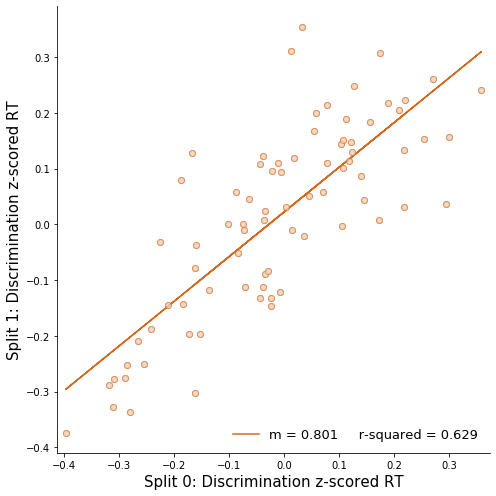

In [272]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X = np.array(m_discrim_RT0_250).reshape(-1,1)
Y = m_discrim_RT1_250
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='chocolate', alpha = 0.3);
plt.plot(X, predicted_Y,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Split 0: Discrimination z-scored RT", fontsize = 15)
plt.ylabel("Split 1: Discrimination z-scored RT", fontsize = 15)

# plt.xlim(6.7, 7.35)
# plt.ylim(6.7, 7.35)
# plt.xticks(np.arange(6.7,7.35, 0.1))
# plt.yticks(np.arange(6.7,7.35, 0.1))


plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();


m: [0.41988978]
b: 0.3718573666433902
R-squared:  0.2862950486118351


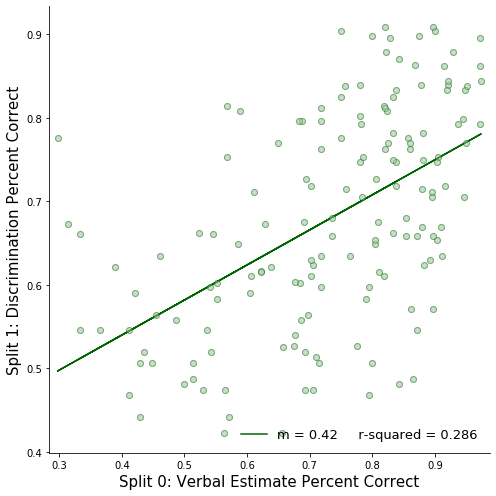

In [273]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
X = np.array(m_VE_performance1_125).reshape(-1,1)
Y = m_discrim_performance0_125
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkgreen', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='darkgreen', alpha = 0.3);
plt.plot(X, predicted_Y,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Split 0: Verbal Estimate Percent Correct", fontsize = 15)
plt.ylabel("Split 1: Discrimination Percent Correct", fontsize = 15)

# plt.xlim(0.2, 1.01)
# plt.ylim(0.2, 1.01)
# plt.xticks(np.arange(0.2,1.2,0.2))
# plt.yticks(np.arange(0.2,1.2,0.2))
plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();

m: [0.63187306]
b: 0.2718076070770068
R-squared:  0.47045939327624103


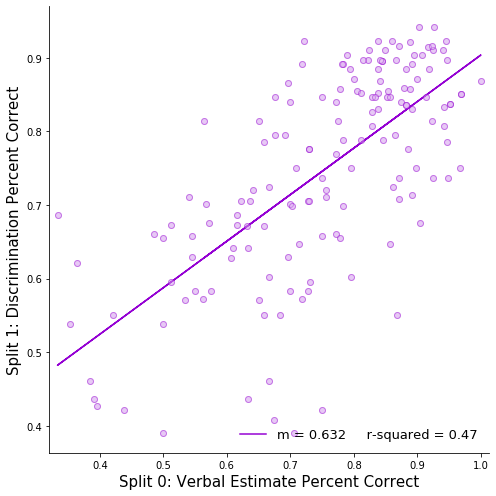

In [274]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
X = np.array(m_VE_performance1_1000).reshape(-1,1)
Y = m_discrim_performance0_1000
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='darkviolet', alpha = 0.3);
plt.plot(X, predicted_Y,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Split 0: Verbal Estimate Percent Correct", fontsize = 15)
plt.ylabel("Split 1: Discrimination Percent Correct", fontsize = 15)

# plt.xlim(0.2, 1.01)
# plt.ylim(0.2, 1.01)
# plt.xticks(np.arange(0.2,1.2,0.2))
# plt.yticks(np.arange(0.2,1.2,0.2))
plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();

m: [-0.53198245]
b: 0.7069785296371747
R-squared:  0.5695804206642006


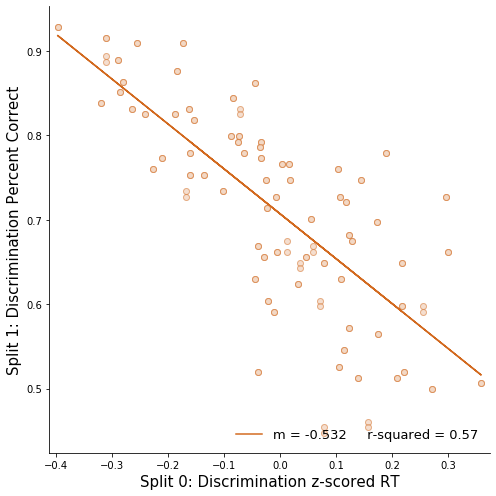

In [275]:
fig, ax = plt.subplots(figsize=[7,7])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)


#run regression
X = np.array(m_discrim_RT0_250).reshape(-1,1)
Y = m_discrim_performance1_250
reg = LinearRegression().fit(X, Y)

#Generated Predictions
predicted_Y = reg.predict(X)
#Plot Our Actual and Predicted Values

plt.errorbar(X, Y, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3);
plt.plot(X, Y, 'o', color='chocolate', alpha = 0.3);
plt.plot(X, predicted_Y,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 4))
         + '     r-squared = ' + str(round(float(reg.score(X, Y)), 3)))

plt.xlabel("Split 0: Discrimination z-scored RT", fontsize = 15)
plt.ylabel("Split 1: Discrimination Percent Correct", fontsize = 15)

# plt.xticks(np.arange(1.6,1.8,0.01))
# plt.yticks(np.arange(0,1,0.2))

plt.margins(x=0.02)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))
#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, Y))

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)
fig.tight_layout()
plt.show();

In [129]:
# mean_df_corr = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/joint_analyses/avg_randSplitMatrix_n5000.csv')
# mean_df_corr


In [141]:
# mean_df_corr = mean_df_corr.set_index('Unnamed: 0')
# mean_df_corr

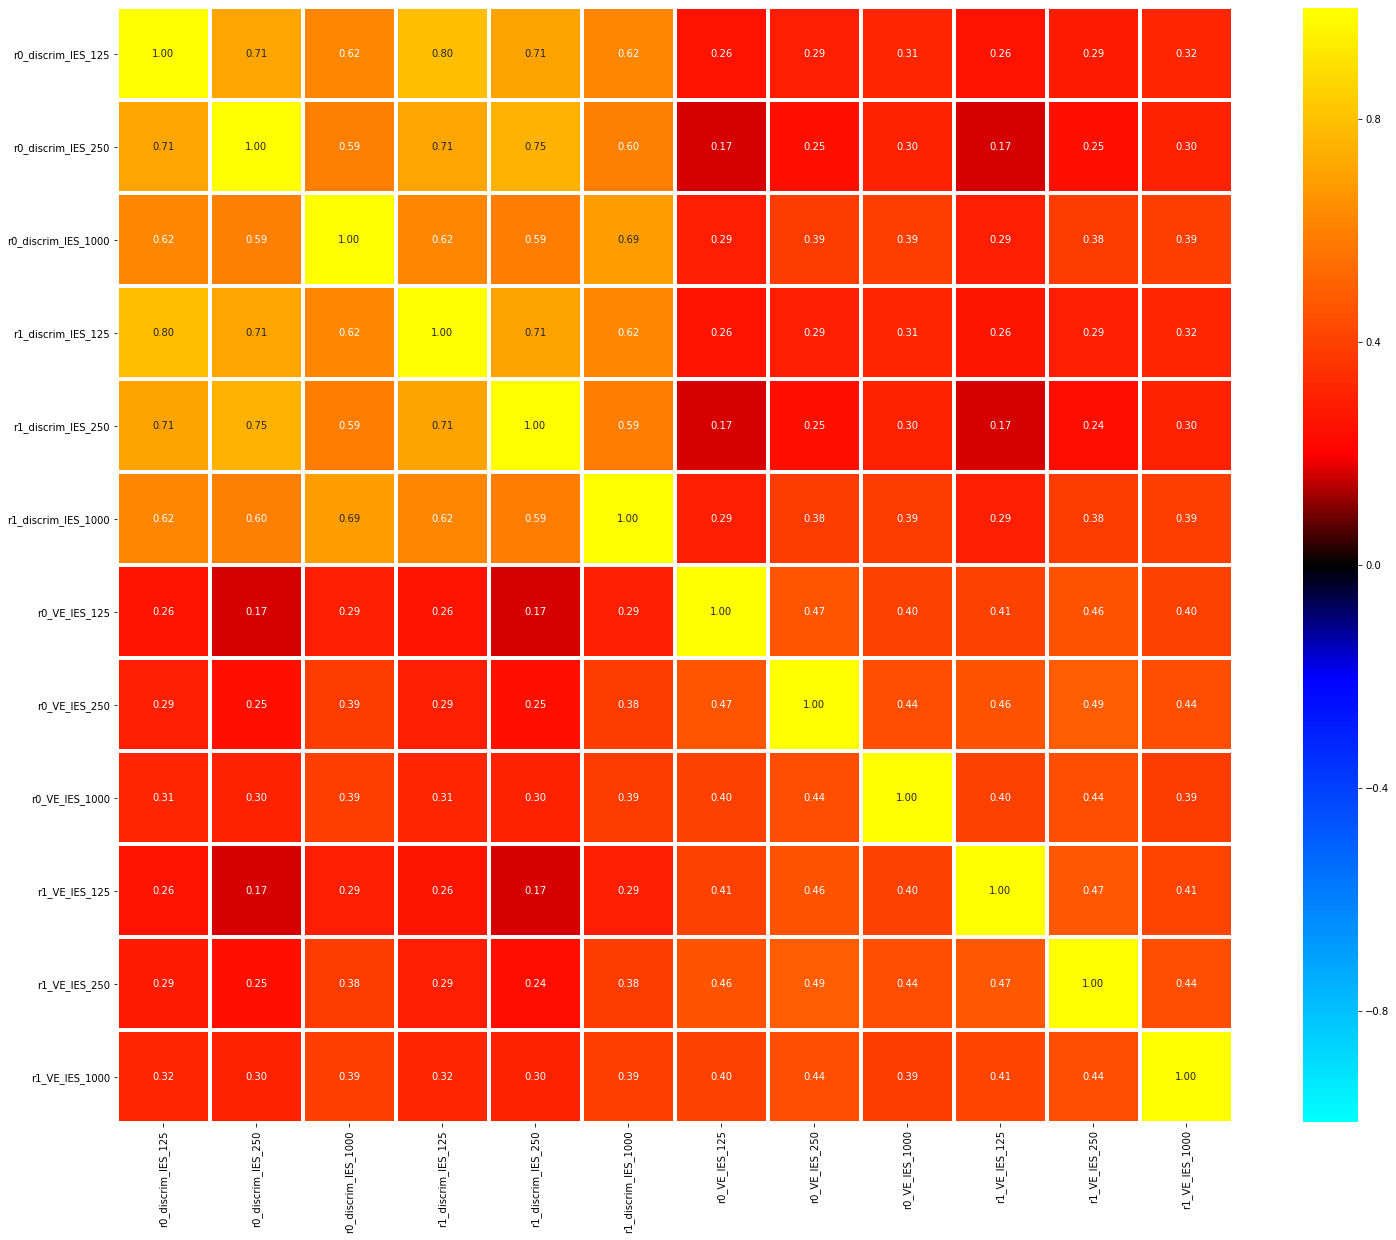

In [47]:
plt.figure(figsize=[25,25])

import matplotlib.colors

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "aqua"],
          [norm(-0.2), "blue"],
          [norm(0), "black"],
          [norm( 0.2), "red"],
          [norm( 1.0), "yellow"]]


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


ax = sns.heatmap(mean_df_corr, annot=True, fmt=".2f", cmap= cmap, square=True, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, ) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.title('Log Centered RT', fontsize=15)

plt.savefig('matrix_IES_5000.png')
plt.savefig('/Users/pmahableshwarkar/Documents/Depth_Project/spatial_perception_SUNRGBD/joint_analyses/matrix_IES_5000.png')

plt.show();


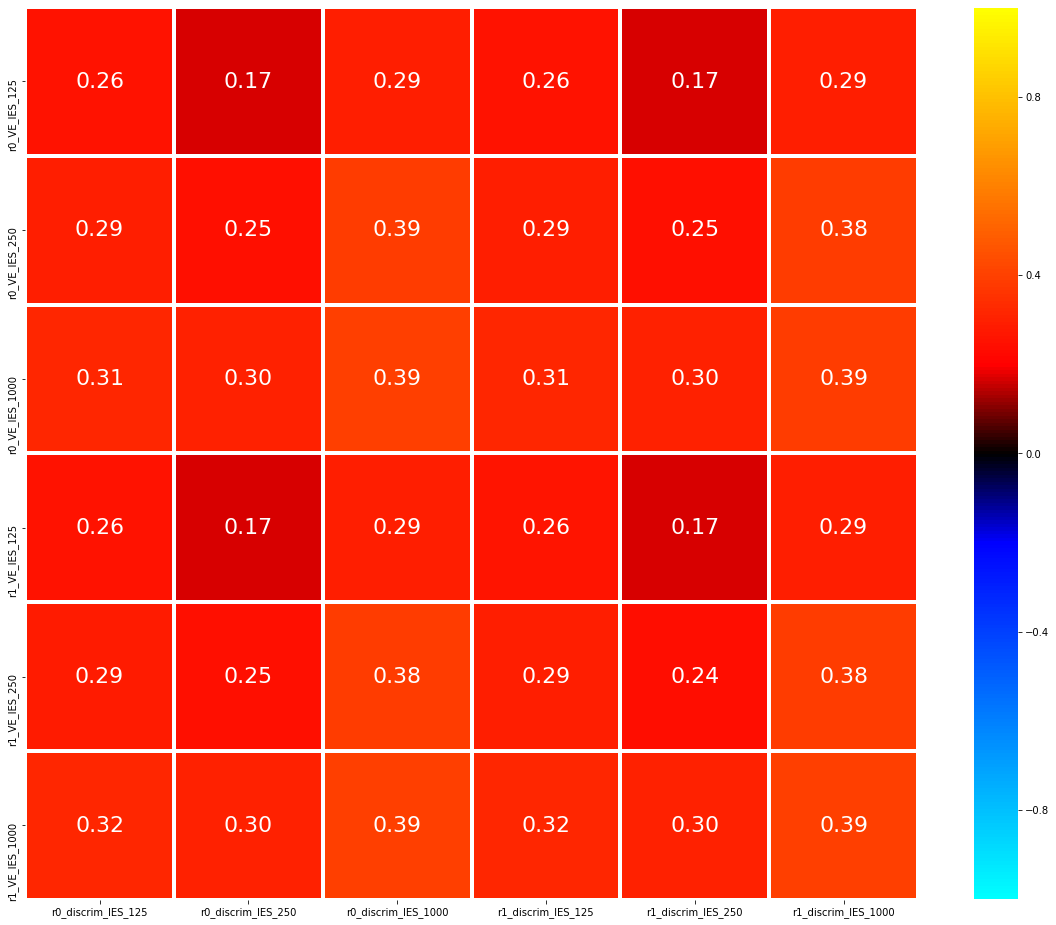

In [46]:
plt.figure(figsize=[20,20])

ax = sns.heatmap(bottom_mean_df_corr, annot=True, fmt=".2f", cmap= cmap, square=True, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={'fontsize': 22, 'color': 'white'}) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.title('Log Centered RT', fontsize=15)

plt.savefig('IES_bottom_rand_' + str(reps) + '.png')
plt.show();
